# Learning an approximate model

In [44]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## The impact of sampling

How do a model's predictions vary with sample size? This is something we can learn very easily by looking at our toy model with the sine curve.

(100,)


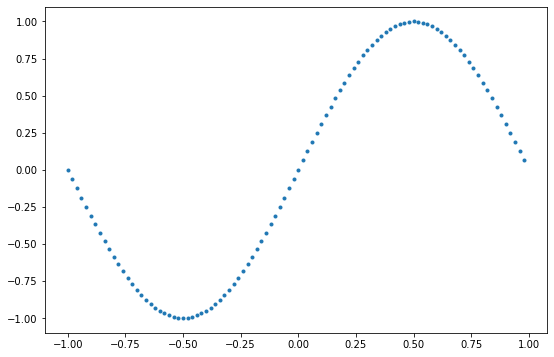

In [46]:
plt.figure(figsize = (9, 6))
xgrid = xs=np.arange(-1.,1.,0.02)
print(xgrid.shape)
f = lambda x: np.sin(np.pi*x)
fgrid = f(xgrid)
plt.plot(xgrid, f(xgrid), '.');

In [47]:
colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']

In [48]:
from sklearn.linear_model import LinearRegression

In [49]:
Xgrid = xgrid.reshape(-1,1)

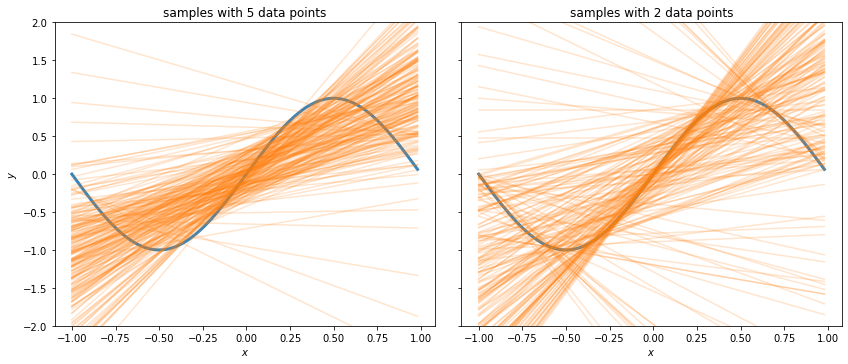

In [50]:
choices5=np.empty((200,5), dtype="int")
choices2=np.empty((200,2), dtype="int")

for i in range(200):
    choices5[i,:] = np.random.choice(xgrid.shape[0], replace=False, size=5)
    choices2[i,:] = np.random.choice(xgrid.shape[0], replace=False, size=2)
axes=make_simple_plot()
c=colors[1]
axes[0].plot(xgrid, fgrid, alpha=0.9, lw=3)
axes[1].plot(xgrid, fgrid, alpha=0.9, lw=3)
for i in range(200):
    l5 = LinearRegression()
    l2 = LinearRegression()
    p5=l5.fit(xgrid[choices5[i,:]].reshape(-1,1), fgrid[choices5[i,:]]).predict(Xgrid)
    p2=l2.fit(xgrid[choices2[i,:]].reshape(-1,1), fgrid[choices2[i,:]]).predict(Xgrid)
    axes[0].plot(xgrid, p5, color=c, alpha=0.2)
    axes[1].plot(xgrid, p2, color=c, alpha=0.2)
axes[0].set_title("samples with 5 data points");
axes[1].set_title("samples with 2 data points");

## The process of learning

There are challenges that occur in learning a model from data:

- small samples of data
- noise in the data

Let us first ask the question: what is he process of learning from data in the absence of noise. This never really happens, but it is a way for us to understand the theory of **approximation**, and lets us build a base for understanding the learning from data with noise.

Lets say we are trying to predict is a human process such as an election. Here economic and sociological factors are important, such as poverty, race and religiousness. There are historical correlations between such factors and election outcomes which we might want to incorporate into our model. An example of such a model might be:

*The odds of Romney winning a county against Obama in 2012 are a function of population religiosity, race, poverty, education, and other social and economic indicators.*

Our **causal** argument motivating this model here might be that religious people are more socially conservative and thus more likely to vote republican. This might not be the correct causation, but thats not entirely important for the prediction. 

As long as a **correlation** exists, our model is more structured than 50-50 randomness, and we can try and make a prediction. Remember of-course, our model may even be wrong (see Box's aphorism: https://en.wikipedia.org/wiki/All_models_are_wrong).

We'll represent the variable being predicted, such as the probability of voting for Romney, by the letter $y$, and the **features** or **co-variates** we use as an input in this probability by the letter $x$. This $x$ could be multi-dimensional, with $x_1$ being poverty, $x_2$ being race, and so on.

We then write 

$$ y = f(x) $$

and our jobs is to take $x$ such as data from the census about race, religiousness, and so on, and $y$ as previous elections and the results of polls that pollsters come up with, and to make a predictive model for the elections. That is, we wish to estimate $f(x)$.

### A real simple model

To gently step feet in the modelling world, consider a very simple scenario, where the probability of voting for Romney is a function only of how religious the population in a county is. This is a model I've cooked up, and the data is fake. 

Let $x$ be the fraction of religious people in a county and $y$ be the fraction of people voting for Romney as a function of $x$. In other words $y_i$ is data that pollsters have taken which tells us their estimate of the fraction of people voting for Romney and $x_i$ is the fraction of religious people in county $i$. Because poll samples are finite, there is a margin of error on each data point or county $i$, but we will ignore that for now.

Let us assume that we have a "population" of 200 counties $x$:

In [51]:
df=pd.read_csv("data/religion.csv")
df.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


Lets suppose now that the Lord came by and told us that the points in the plot below captures $f(x)$ exactly. In other words, there is no specification error, and  God knows the generating process exactly.

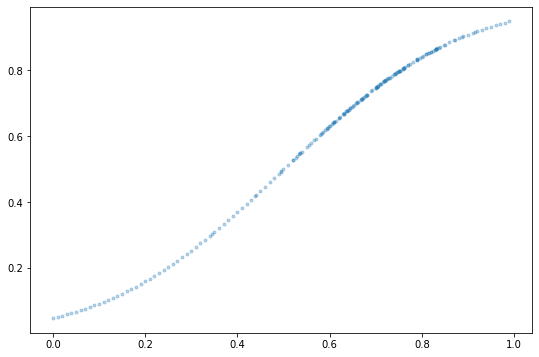

In [52]:
x=df.rfrac.values
f=df.promney.values
plt.figure(figsize = (9,6))
plt.plot(x,f,'.', alpha=0.3)

Notice that our sampling of $x$ is not quite uniform: there are more points around $x$ of 0.7.

Now, in real life we are only given a sample of points. Lets assume that out of this population of 200 points we are given a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, the entire population of data points is also called **out-of-sample data**.

Here are the indices from this sample.

In [53]:
#indexes=np.sort(np.random.choice(x.shape[0], size=30, replace=False))
dfsample = pd.read_csv("data/noisysample.csv")
dfsample.head()

,f,i,x,y
0,0.075881,7,0.07,0.138973
1,0.085865,9,0.09,0.050510
2,0.096800,11,0.11,0.183821
3,0.184060,23,0.23,0.057621
4,0.285470,33,0.33,0.358174


In [54]:
indexes = dfsample.i.values

In [55]:
samplex = x[indexes]
samplef = f[indexes]

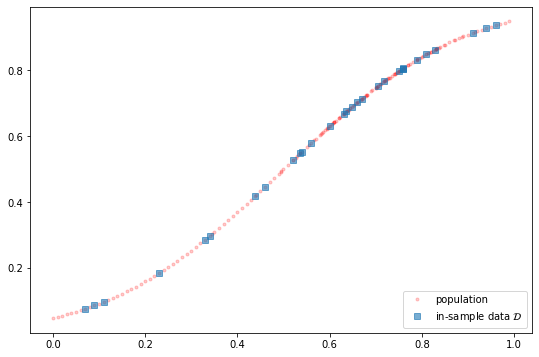

In [56]:
plt.figure(figsize = (9,6))
plt.plot(x,f, 'r.', alpha=0.2, label="population");
plt.plot(samplex,samplef, 's', alpha=0.6, label="in-sample data $\cal{D}$");
plt.legend(loc=4);

The lightly shaded squares in the right panel plot are the in-sample $\cal{D}$ of 30 points given to us. Let us then pretend that we have forgotten the curve that the Lord gave us. Thus, all we know is the blue points on the plot on the right, and we have no clue about what the original curve was, nor do we remember the original "population".

That is, imagine the Lord gave us $f$ but then also gave us amnesia. Remember that such amnesia is the general case in learning, where we *do not know* the target function, but rather just have some data. Thus what we will be doing is *trying to find functions that might have generated the 30 points of data that we can see* in the hope that one of these functions might approximate $f$ well, and provide us a **predictive model** for future data. This is known as **fitting** the data.


Let us consider as the function we used to fit the data, a hypothesis $h$ that is a straight line. We put the subscript $1$ on the $h$ to indicate that we are fitting the data with a polynomial of order 1, or a straight line. This looks like:

$$ h_1(x) = a_0 + a_1 x $$

We'll call the **best fit** straight line the function $g_1(x)$. The "best fit" idea is this: amongst the set of all lines (i.e., all possible choices of $h_1(x)$), what is the best line $g_1(x)$ that represents the in-sample data we have? (The subscript $1$ on $g$ is chosen to indicate the best fit polynomial of degree 1, ie the line amongst lines that fits the data best).

To do this, we use an algorithm, called the **learner**, which chooses functions from a hypothesis set $\cal{H}$ and computes a cost measure or risk functional $R$ (like the sum of the squared distance over all points in the data set) for each of these functions. It then chooses the function $g$ which **minimizes** this cost measure amonst all the functions in $\cal{H}$, and thus gives us a final hypothesis $g$ which we then use to approximate or estimate f **everywhere**, not just at the points in our data set. 

Here our learner is called **Polynomial Regression**, and it takes a hypothesis space $\cal{H}_d$ of degree $d$ polynomials, minimizes the "squared-error" risk measure, and spits out a best-fit hypothesis $g_d$.

![](images/BasicModel.png)

(This diagram is based on the one in Yaser Abu-Mustafa's excellent book, Learning From Data.)

The best fit $g_1(x)$ is calculated and shown in the figure below:

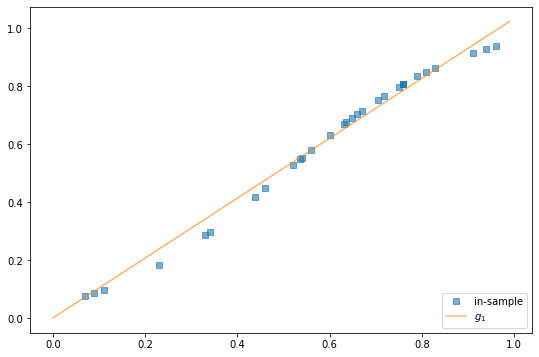

In [57]:
g1 = LinearRegression(fit_intercept=False).fit(x[indexes].reshape(-1,1),f[indexes]).predict(
    x.reshape(-1,1))
plt.figure(figsize = (9,6))
plt.plot(x[indexes],f[indexes], 's', alpha=0.6, label="in-sample");
plt.plot(x,g1, alpha=0.6, label="$g_1$");
plt.legend(loc=4);

## Deterministic Error or Bias

Notice from the figure above that models in $\cal{H}_1$, i.e., straight lines, and the best-fit straight line $g_1$ in particular, do not do a very good job of capturing the curve of  the data (and thus the underlying function $f$ that we are trying to approximate. Consider the more general case in the figure below, where a curvy $f$ is approximated by a function $g$ which just does not have the wiggling that $f$ has. 

![m:Bias](images/bias.png)

There is always going to be an error then, in approximating $f$ by $g$. This *approximation error* is shown in the figure by the blue shaded region, and its called **bias**, or **deterministic error**. The former name comes from the fact that $g$ just does not wiggle the way $f$ does (nothing will make a straight line curve). The latter name (which I first saw used in http://www.amlbook.com/ ) comes from the notion that if you did not know the target function $f$, which is the case in most learning situations, you would have a hard time distinguishing this error from any other errors such as measurement and noise...

Going back to our model at hand, it is clear that the space of 
straight lines $\cal{H_1}$ does not capture the curving in the data. So let us consider the more complex hypothesis space $\cal{H_{20}}$, the set of all 20th order 
polynomials $h_{20}(x)$:

$$h_{20}(x) = \sum_{i=0}^{20} a_i x^i\,.$$


To see how a more complex hypothesis space does, lets find the best fit 20th order polynomial $g_{20}(x)$.

In [58]:
from sklearn.preprocessing import PolynomialFeatures
def polyshape(d, xgrid):
    return PolynomialFeatures(d).fit_transform(xgrid.reshape(-1,1))
g20 = LinearRegression(fit_intercept=False).fit(polyshape(20,x[indexes]),f[indexes]).predict(
        polyshape(20,x))

In [59]:
l = LinearRegression(fit_intercept=False).fit(polyshape(20,x[indexes]),f[indexes])

In [61]:
l.coef_

array([  0.04779044,   0.33158545,   0.92121618,   1.08965931,
        -0.16984035,  -2.16419641,  -0.94309234,  -0.92323111,
         8.9915213 , -11.16582321,  11.59820085, -10.90904575,
        -1.38216163,  13.67141592,  -7.70960938,  -6.71540156,
        11.46219689,  -6.97185608,   2.26020518,  -0.40012151,
         0.03279746])

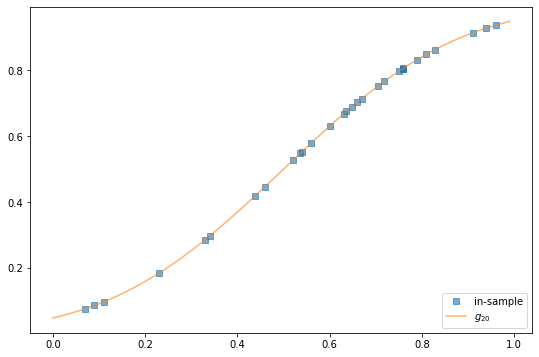

In [62]:
plt.figure(figsize = (9,6))
plt.plot(x[indexes],f[indexes], 's', alpha=0.6, label="in-sample");
plt.plot(x, g20, alpha=0.6, label="$g_{20}$");
plt.legend(loc=4);

Voila! You can see the 20th order polynomial does a much better job of tracking the points, because of the wiggle room it has in making a curve "go near or through" all the points as opposed to a straight line, which well, cant curve. Thus it would seem that $\cal{H}_{20}$ might be a better candidate hypothesis set from which to choose a best fit model. 

We can quantify this by calculating some notion of the bias for both $g_1$ and $g_{20}$. 
To do this we calculate the square of the difference between f and the g's on the population of 200 points i.e.:

$$B_1(x) = (g_1(x) - f(x))^2 \,;\,\, B_{20}(x) = (g_{20}(x) - f(x))^2\,.$$ 

Squaring makes sure that we are calculating a positive quantity.

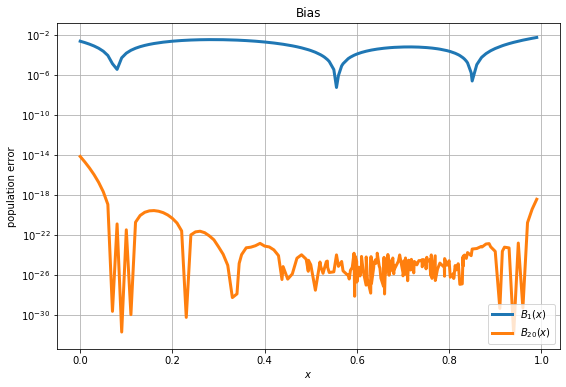

In [63]:
plt.figure(figsize = (9,6))
plt.plot(x, (g1-f)**2, lw=3, label="$B_1(x)$")
plt.plot(x, (g20-f)**2, lw=3,label="$B_{20}(x)$");
plt.xlabel("$x$")
plt.ylabel("population error")
plt.yscale("log")
plt.legend(loc=4);
plt.grid()
plt.title("Bias");

As you can see the **bias or approximation error** is much smaller for $g_{20}$.

Is $g_{20}$ the best model for this data from all possible models, both from within the ${\cal H_{20}}$ hypothesis space and from outside? Indeed, how do we find the best fit model from the best hypothesis space? This is what **learning** is all about.


## Learning needs Out-of-Sample prediction

We write $g \approx f$, or $g$ is the **estimand** of $f$.In statistics books you will see $g$ written as $\hat{f}$. 

Why do we think that this might be a good idea? What are we really after?

What we'd like to do is **make good predictions**. In the language of cost, what we are really after is to minimize the cost **out-of-sample**, on the **population** at large. But this presents us with a conundrum: *how can we minimize the risk on points we havent yet seen*?

This is why we (a) minimize the risk on the set of points that we have to find $g$ and then (b) hope that once we have found our best model $g$, our risk does not particularly change out-of-sample, or when using a different set of points, and it remains low!

We are, as is usual in statistics, **drawing conclusions about a population from a sample**. 

### How representative is our sample?

Intuitively, to do this, we need to ask ourselves, how representative is our sample? Or more precisely, how representative is our sample of our training points of the population (or for that matter the new x that we want to predict for)? 

We illustrate this below for our population of 200 data points and our sample of 30 data points (in red).

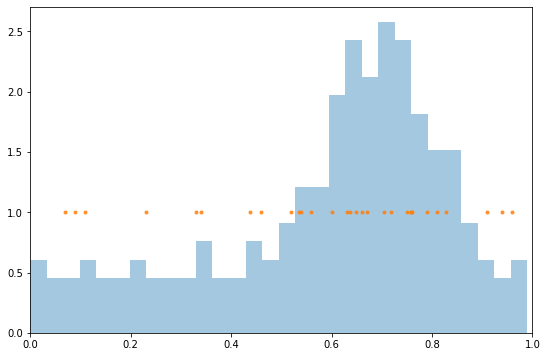

In [64]:
plt.figure(figsize = (9,6))
plt.hist(x, density=True, bins=30, alpha=0.4)
plt.plot(x[indexes], [1.0]*len(indexes),'.', alpha=0.8)
plt.xlim([0,1]);

In our example, if we only want to use $g$, our estimand of $f$ to predict for large $x$, or more religious counties, we would need a good sampling of points $x$ closer to 1. And, similarly, the new $x$ we are using to make predictions would also need to be representative of those counties. We wont do well if we try and predict low-religiousness counties from a sample of high-religiousness ones. Or, if we do want to predict over the entire range of religiousness, our training sample better cover all $x$ well.

Our sample points seem to follow our (god given) histogram well.

## Statement of the learning problem.

Once we have done that, we can then intuitively say that, if we find a hypothesis $g$ that minimizes the cost or risk over the training set; this hypothesis *might* do a good job over the population that the training set was representative of, since the risk on the population ought to be similar to that on the training set, and thus small.

Mathematically, we are saying that:

$$
\begin{eqnarray*}
A &:& R_{\cal{D}}(g) \,\,smallest\,on\,\cal{H}\\
B &:& R_{out} (g) \approx R_{\cal{D}}(g)
\end{eqnarray*}
$$

In other words, we hope the **sample or empirical risk estimates the out of sample risk well, and thus the out of sample risk is also small**.

Indeed, as we can see below, $g_{20}$ does an excellent job on the population, not just on the sample.

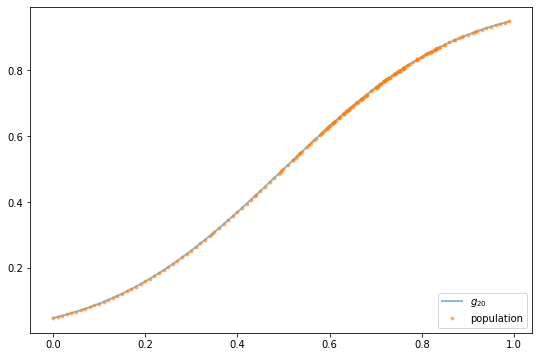

In [65]:
plt.figure(figsize = (9,6))
plt.plot(x,g20, alpha=0.5, lw=2, label="$g_{20}$");
plt.plot(x,f, '.', alpha=0.5, label="population");
plt.legend(loc=4);